## Stock Movement Analysis  
This project focuses on developing a machine learning model to predict stock price movements by analyzing social media data. Using Reddit as the primary data source, the project involves scraping stock-related discussions and extracting insights through sentiment analysis and topic modeling. The processed data is fed into a predictive model, whose accuracy is validated using historical stock trends, with Alpha Vantage API providing reliable stock data for evaluation.

In [2]:
#Install `praw` for Reddit data scraping and `pandas` for efficient data preprocessing.
!pip install praw pandas

In [3]:
#Create a `config.py` file to securely store Reddit API credentials (`CLIENT_ID`, `CLIENT_SECRET`, and `USER_AGENT`) for accessing Reddit data.
with open("config.py", "w") as file:
    file.write('CLIENT_ID = "QD8cng77Jgg5ARvFmhGKOw"\n')
    file.write('CLIENT_SECRET = "KEbY6tvI0AUqFHOsfQDhv65JzhOnRA"\n')
    file.write('USER_AGENT = "your_user_agent"\n')


In [4]:
import praw
import pandas as pd
from config import CLIENT_ID, CLIENT_SECRET, USER_AGENT

In [5]:
# Initialize Reddit API client
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

## Data extraction and cleaning
This script collects and filters posts from the "stocks" subreddit, focusing on keywords related to stock movements, such as "buy," "sell," "prediction," etc. It retrieves details like the post title, score, ID, URL, creation date, body, and the number of comments. The data is then stored in a structured format using a Pandas DataFrame and exported to a CSV file, `reddit_posts_with_comments_count_and_dates.csv`, for further analysis of stock-related discussions.

In [7]:
from datetime import datetime

subreddit = reddit.subreddit("stocks")  
keywords = [
    'stock', 'shares', 'equity', 'ticker', 'investment', 'trading',
    'buy', 'sell', 'hold', 'invest', 'trade', 
    'bullish', 'bearish', 'prediction', 'forecast', 'rally', 'dip'
]

posts = []
for post in subreddit.hot(limit=None): 
    if any(keyword in post.title.lower() for keyword in keywords):
        post_data = {
            "title": post.title,
            "score": post.score,
            "id": post.id,
            "url": post.url,
            "created": post.created,
            "posted_date": datetime.fromtimestamp(post.created).strftime('%Y-%m-%d'),  
            "body": post.selftext,
            "num_comments": post.num_comments 
        }
        posts.append(post_data)

df = pd.DataFrame(posts)

df.to_csv("reddit_posts_with_comments_count_and_dates.csv", index=False)

print("Scraped data saved to 'reddit_posts_with_comments_count_and_dates.csv'")


Scraped data saved to 'reddit_posts_with_comments_count_and_dates.csv'


In [8]:
df.head()

,title,score,id,url,created,posted_date,body,num_comments
0,r/Stocks Daily Discussion & Fundamentals Frida...,23,1grtfyq,https://www.reddit.com/r/stocks/comments/1grtf...,1.731667e+09,2024-11-15,"This is the daily discussion, so anything stoc...",463
1,r/Stocks Daily Discussion & Technicals Tuesday...,6,1h08ta0,https://www.reddit.com/r/stocks/comments/1h08t...,1.732617e+09,2024-11-26,"This is the daily discussion, so anything stoc...",87
2,These are the stocks on my watchlist (11/26),17,1h0co9w,https://www.reddit.com/r/stocks/comments/1h0co...,1.732630e+09,2024-11-26,# I'm back.\n\nHi! I am an ex-prop shop equity...,12
3,"Long term investors, what’s your thoughts on r...",2,1h0ej8h,https://www.reddit.com/r/stocks/comments/1h0ej...,1.732635e+09,2024-11-26,"I’m pretty young, and have only been doing thi...",8
4,Why MicroStrategy Stock Rocketed 24.7% Higher ...,200,1gzglu6,https://www.reddit.com/r/stocks/comments/1gzgl...,1.732534e+09,2024-11-25,MicroStrategy has been the talk of YouTube lat...,96


This script cleans the text data in Reddit post titles and bodies by removing non-alphabetic characters, converting text to lowercase, and eliminating common stopwords using NLTK. The cleaned text is stored in new columns (clean_title and clean_body) for further analysis, ensuring a more standardized and meaningful dataset.

In [10]:
import re
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

# Clean text function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower() 
    stop_words = set(stopwords.words('english')) 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_title'] = df['title'].apply(clean_text)
df['clean_body'] = df['body'].apply(clean_text)

df[['title', 'clean_title', 'body', 'clean_body']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,clean_title,body,clean_body
0,r/Stocks Daily Discussion & Fundamentals Frida...,rstocks daily discussion fundamentals friday nov,"This is the daily discussion, so anything stoc...",daily discussion anything stocks related fine ...
1,r/Stocks Daily Discussion & Technicals Tuesday...,rstocks daily discussion technicals tuesday nov,"This is the daily discussion, so anything stoc...",daily discussion anything stocks related fine ...
2,These are the stocks on my watchlist (11/26),stocks watchlist,# I'm back.\n\nHi! I am an ex-prop shop equity...,im back hi exprop shop equity trader daily wat...
3,"Long term investors, what’s your thoughts on r...",long term investors whats thoughts recent vfvv...,"I’m pretty young, and have only been doing thi...",im pretty young couple years putting money vfv...
4,Why MicroStrategy Stock Rocketed 24.7% Higher ...,microstrategy stock rocketed higher week,MicroStrategy has been the talk of YouTube lat...,microstrategy talk youtube lately posters bull...


In [11]:
df.isnull().sum()

title           0
score           0
id              0
url             0
created         0
posted_date     0
body            0
num_comments    0
clean_title     0
clean_body      0
dtype: int64

## Sentiment Analysis part

In [13]:
#effective in assessing the sentiment of text data such as social media posts and comments.
!pip install vaderSentiment

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound'] 
df['title_sentiment'] = df['clean_title'].apply(get_sentiment)
df['body_sentiment'] = df['clean_body'].apply(get_sentiment)

df[['title', 'title_sentiment', 'clean_title', 'body', 'body_sentiment', 'clean_body']].head(20)

,title,title_sentiment,clean_title,body,body_sentiment,clean_body
0,r/Stocks Daily Discussion & Fundamentals Frida...,0.0000,rstocks daily discussion fundamentals friday nov,"This is the daily discussion, so anything stoc...",0.9640,daily discussion anything stocks related fine ...
1,r/Stocks Daily Discussion & Technicals Tuesday...,0.0000,rstocks daily discussion technicals tuesday nov,"This is the daily discussion, so anything stoc...",0.9325,daily discussion anything stocks related fine ...
2,These are the stocks on my watchlist (11/26),0.0000,stocks watchlist,# I'm back.\n\nHi! I am an ex-prop shop equity...,0.9062,im back hi exprop shop equity trader daily wat...
3,"Long term investors, what’s your thoughts on r...",0.0000,long term investors whats thoughts recent vfvv...,"I’m pretty young, and have only been doing thi...",0.9154,im pretty young couple years putting money vfv...
4,Why MicroStrategy Stock Rocketed 24.7% Higher ...,0.0000,microstrategy stock rocketed higher week,MicroStrategy has been the talk of YouTube lat...,0.2486,microstrategy talk youtube lately posters bull...
5,How is DCA in s&p500 such a superior strategy ...,0.5423,dca sp superior strategy compared strategies a...,"Hello,\n\nSo what I did was, take daily data o...",0.1280,hello take daily data sp last years scenario p...
6,"r/Stocks Daily Discussion Monday - Nov 25, 2024",0.0000,rstocks daily discussion monday nov,These daily discussions run from Monday to Fri...,0.7650,daily discussions run monday friday including ...
7,TIL You can invest in SpaceX and Xai -- but yo...,0.0000,til invest spacex xai via cathy woods sofi,"Cathy Wood's Venture Fund, ArkVX holds compani...",0.6705,cathy woods venture fund arkvx holds companies...
8,How are activist short sellers not committing ...,0.0772,activist short sellers committing insider trading,It seems like they gain access to material non...,0.9081,seems like gain access material nonpublic info...
9,Stock events this week,0.0000,stock events week,"Hello, I was wondering which event is bigger i...",0.2115,hello wondering event bigger terms stock marke...


In [15]:
# cleaned data
df[['title', 'title_sentiment', 'clean_title', 'body', 'body_sentiment', 'clean_body']].head(20)

,title,title_sentiment,clean_title,body,body_sentiment,clean_body
0,r/Stocks Daily Discussion & Fundamentals Frida...,0.0000,rstocks daily discussion fundamentals friday nov,"This is the daily discussion, so anything stoc...",0.9640,daily discussion anything stocks related fine ...
1,r/Stocks Daily Discussion & Technicals Tuesday...,0.0000,rstocks daily discussion technicals tuesday nov,"This is the daily discussion, so anything stoc...",0.9325,daily discussion anything stocks related fine ...
2,These are the stocks on my watchlist (11/26),0.0000,stocks watchlist,# I'm back.\n\nHi! I am an ex-prop shop equity...,0.9062,im back hi exprop shop equity trader daily wat...
3,"Long term investors, what’s your thoughts on r...",0.0000,long term investors whats thoughts recent vfvv...,"I’m pretty young, and have only been doing thi...",0.9154,im pretty young couple years putting money vfv...
4,Why MicroStrategy Stock Rocketed 24.7% Higher ...,0.0000,microstrategy stock rocketed higher week,MicroStrategy has been the talk of YouTube lat...,0.2486,microstrategy talk youtube lately posters bull...
5,How is DCA in s&p500 such a superior strategy ...,0.5423,dca sp superior strategy compared strategies a...,"Hello,\n\nSo what I did was, take daily data o...",0.1280,hello take daily data sp last years scenario p...
6,"r/Stocks Daily Discussion Monday - Nov 25, 2024",0.0000,rstocks daily discussion monday nov,These daily discussions run from Monday to Fri...,0.7650,daily discussions run monday friday including ...
7,TIL You can invest in SpaceX and Xai -- but yo...,0.0000,til invest spacex xai via cathy woods sofi,"Cathy Wood's Venture Fund, ArkVX holds compani...",0.6705,cathy woods venture fund arkvx holds companies...
8,How are activist short sellers not committing ...,0.0772,activist short sellers committing insider trading,It seems like they gain access to material non...,0.9081,seems like gain access material nonpublic info...
9,Stock events this week,0.0000,stock events week,"Hello, I was wondering which event is bigger i...",0.2115,hello wondering event bigger terms stock marke...


In [16]:
# Display a sample of the data with the original, cleaned text, and sentiment scores
sample_data = df[['title', 'clean_title', 'body', 'clean_body', 'title_sentiment', 'body_sentiment']].sample(10)
print(sample_data)

                                                title  \
42                          S&P 500 Rebalancing Trade   
20  Why is NVO willing to sell drugs at such low p...   
67  Spotify Tops Q3 Forecasts, Reaches 252 Million...   
75  Investing in INDA & SMIN, hoping for Indian ET...   
8   How are activist short sellers not committing ...   
61       SoundHound AI Stock Tumbles as Margins Drop    
41                              Trading SPY for gains   
16  Are we putting too much faith in generative AI...   
64  Distribution of your assets between cash/stock...   
44    r/Stocks Daily Discussion Monday - Nov 18, 2024   

                                          clean_title  \
42                               sp rebalancing trade   
20             nvo willing sell drugs low price china   
67  spotify tops q forecasts reaches million premi...   
75  investing inda smin hoping indian etfsto conti...   
8   activist short sellers committing insider trading   
61           soundhound ai sto

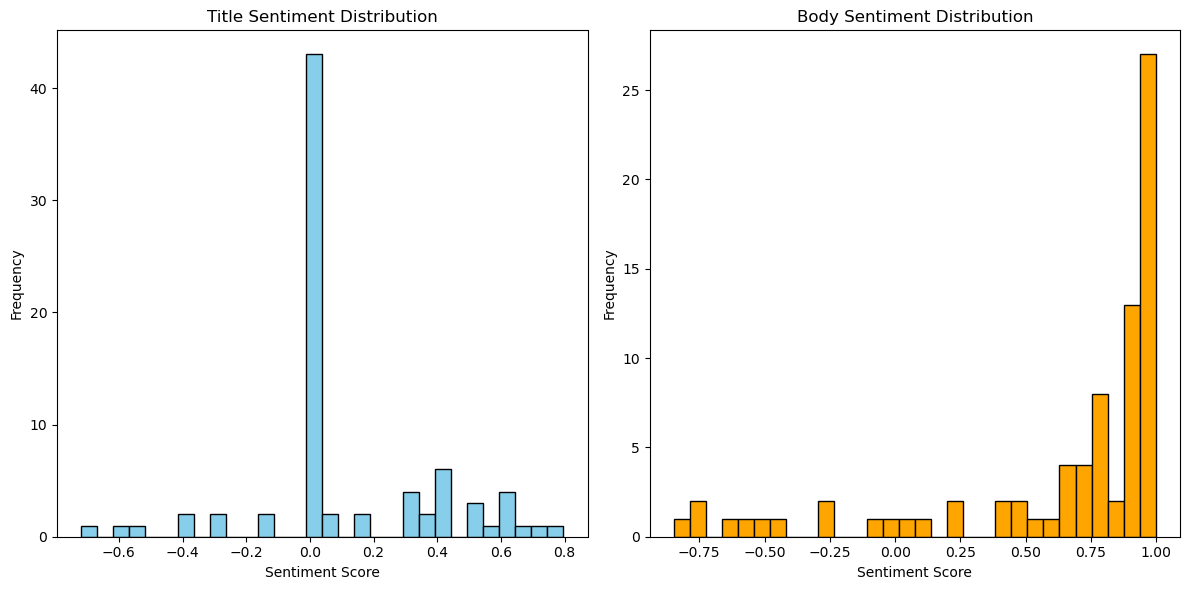

In [17]:
#Visualizes the sentiment distribution of Reddit post titles and bodies using histograms to show the frequency of sentiment scores.
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['title_sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.title('Title Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['body_sentiment'], bins=30, color='orange', edgecolor='black')
plt.title('Body Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

####  Assigns sentiment labels ('positive', 'negative', or 'neutral') to both the title and body sentiment scores based

In [19]:
def get_sentiment_label(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['title_sentiment_label'] = df['title_sentiment'].apply(get_sentiment_label)
df['body_sentiment_label'] = df['body_sentiment'].apply(get_sentiment_label)

df[['title', 'title_sentiment', 'title_sentiment_label', 'body', 'body_sentiment', 'body_sentiment_label']].head(20)

,title,title_sentiment,title_sentiment_label,body,body_sentiment,body_sentiment_label
0,r/Stocks Daily Discussion & Fundamentals Frida...,0.0000,neutral,"This is the daily discussion, so anything stoc...",0.9640,positive
1,r/Stocks Daily Discussion & Technicals Tuesday...,0.0000,neutral,"This is the daily discussion, so anything stoc...",0.9325,positive
2,These are the stocks on my watchlist (11/26),0.0000,neutral,# I'm back.\n\nHi! I am an ex-prop shop equity...,0.9062,positive
3,"Long term investors, what’s your thoughts on r...",0.0000,neutral,"I’m pretty young, and have only been doing thi...",0.9154,positive
4,Why MicroStrategy Stock Rocketed 24.7% Higher ...,0.0000,neutral,MicroStrategy has been the talk of YouTube lat...,0.2486,positive
5,How is DCA in s&p500 such a superior strategy ...,0.5423,positive,"Hello,\n\nSo what I did was, take daily data o...",0.1280,positive
6,"r/Stocks Daily Discussion Monday - Nov 25, 2024",0.0000,neutral,These daily discussions run from Monday to Fri...,0.7650,positive
7,TIL You can invest in SpaceX and Xai -- but yo...,0.0000,neutral,"Cathy Wood's Venture Fund, ArkVX holds compani...",0.6705,positive
8,How are activist short sellers not committing ...,0.0772,neutral,It seems like they gain access to material non...,0.9081,positive
9,Stock events this week,0.0000,neutral,"Hello, I was wondering which event is bigger i...",0.2115,positive


In [22]:
#counts the mentions of specific stock symbols 

import re
stock_symbols = ['AMD', 'AAPL', 'TSLA', 'MSFT', 'GOOG']
def count_stock_mentions(text, symbols):
    mentions = {}
    for symbol in symbols:
        mentions[symbol] = len(re.findall(r'\b' + re.escape(symbol) + r'\b', text))
    return mentions

df['title_mentions'] = df['title'].apply(lambda x: count_stock_mentions(x, stock_symbols))
df['body_mentions'] = df['body'].apply(lambda x: count_stock_mentions(x, stock_symbols))

df['total_mentions'] = df['title_mentions'].apply(lambda x: sum(x.values())) + df['body_mentions'].apply(lambda x: sum(x.values()))

df[['title', 'title_mentions', 'body', 'body_mentions', 'total_mentions']].head(20)

,title,title_mentions,body,body_mentions,total_mentions
0,r/Stocks Daily Discussion & Fundamentals Frida...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...","This is the daily discussion, so anything stoc...","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
1,r/Stocks Daily Discussion & Technicals Tuesday...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...","This is the daily discussion, so anything stoc...","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
2,These are the stocks on my watchlist (11/26),"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",# I'm back.\n\nHi! I am an ex-prop shop equity...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 2, 'MSFT': 0, 'G...",2
3,"Long term investors, what’s your thoughts on r...","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...","I’m pretty young, and have only been doing thi...","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
4,Why MicroStrategy Stock Rocketed 24.7% Higher ...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",MicroStrategy has been the talk of YouTube lat...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
5,How is DCA in s&p500 such a superior strategy ...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...","Hello,\n\nSo what I did was, take daily data o...","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
6,"r/Stocks Daily Discussion Monday - Nov 25, 2024","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",These daily discussions run from Monday to Fri...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
7,TIL You can invest in SpaceX and Xai -- but yo...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...","Cathy Wood's Venture Fund, ArkVX holds compani...","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
8,How are activist short sellers not committing ...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",It seems like they gain access to material non...,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0
9,Stock events this week,"{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...","Hello, I was wondering which event is bigger i...","{'AMD': 0, 'AAPL': 0, 'TSLA': 0, 'MSFT': 0, 'G...",0


In [23]:
# counts the occurrences of keywords related to market movements 

keywords = ['rally', 'bull', 'bear', 'crash', 'growth', 'dip']

def count_keywords(text, keywords):
    counts = {}
    for keyword in keywords:
        counts[keyword] = len(re.findall(r'\b' + re.escape(keyword) + r'\b', text.lower()))
    return counts

df['title_keywords'] = df['title'].apply(lambda x: count_keywords(x, keywords))
df['body_keywords'] = df['body'].apply(lambda x: count_keywords(x, keywords))
df['total_keywords'] = df['title_keywords'].apply(lambda x: sum(x.values())) + df['body_keywords'].apply(lambda x: sum(x.values()))

df[['title', 'title_keywords', 'body', 'body_keywords', 'total_keywords']].head(20)

,title,title_keywords,body,body_keywords,total_keywords
0,r/Stocks Daily Discussion & Fundamentals Frida...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...","This is the daily discussion, so anything stoc...","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",1
1,r/Stocks Daily Discussion & Technicals Tuesday...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...","This is the daily discussion, so anything stoc...","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0
2,These are the stocks on my watchlist (11/26),"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",# I'm back.\n\nHi! I am an ex-prop shop equity...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0
3,"Long term investors, what’s your thoughts on r...","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...","I’m pretty young, and have only been doing thi...","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",1
4,Why MicroStrategy Stock Rocketed 24.7% Higher ...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",MicroStrategy has been the talk of YouTube lat...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0
5,How is DCA in s&p500 such a superior strategy ...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...","Hello,\n\nSo what I did was, take daily data o...","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0
6,"r/Stocks Daily Discussion Monday - Nov 25, 2024","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",These daily discussions run from Monday to Fri...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0
7,TIL You can invest in SpaceX and Xai -- but yo...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...","Cathy Wood's Venture Fund, ArkVX holds compani...","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0
8,How are activist short sellers not committing ...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",It seems like they gain access to material non...,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0
9,Stock events this week,"{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...","Hello, I was wondering which event is bigger i...","{'rally': 0, 'bull': 0, 'bear': 0, 'crash': 0,...",0


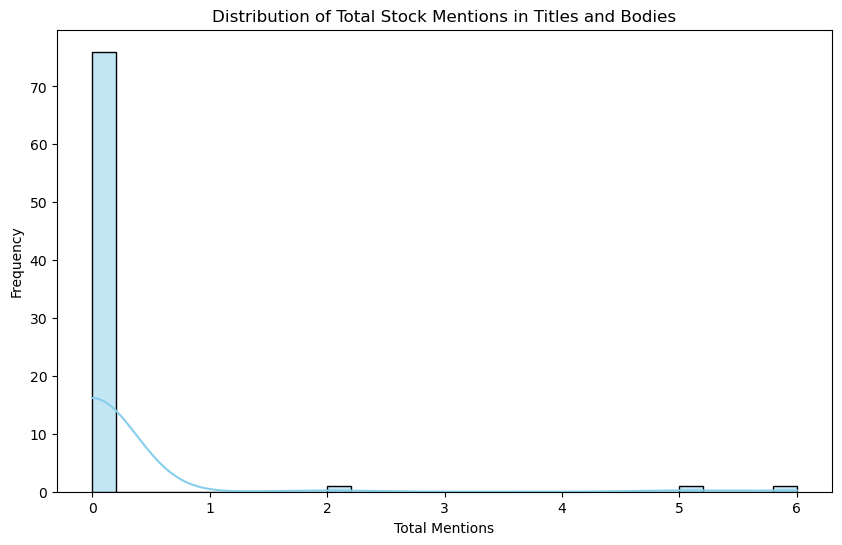

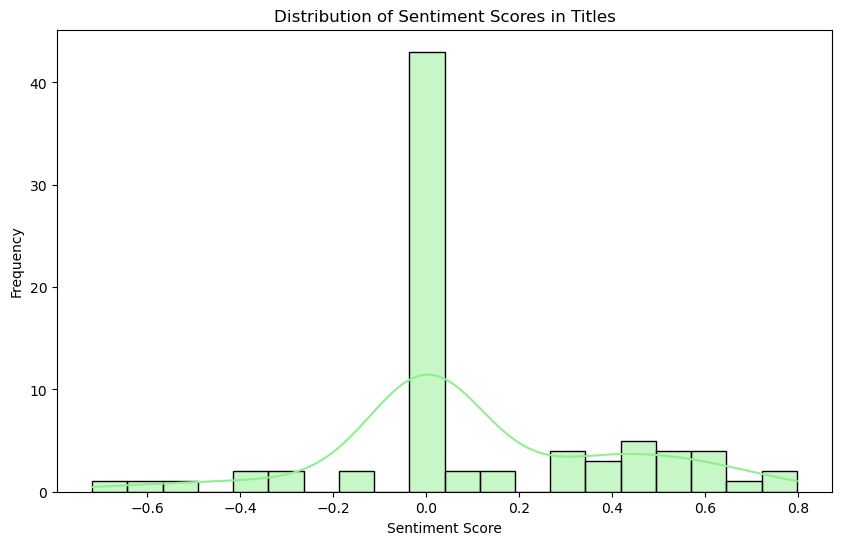

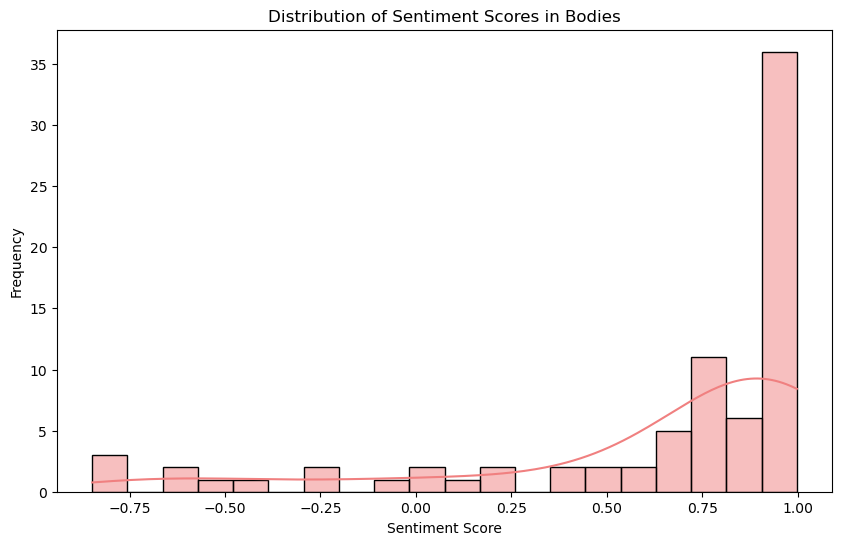

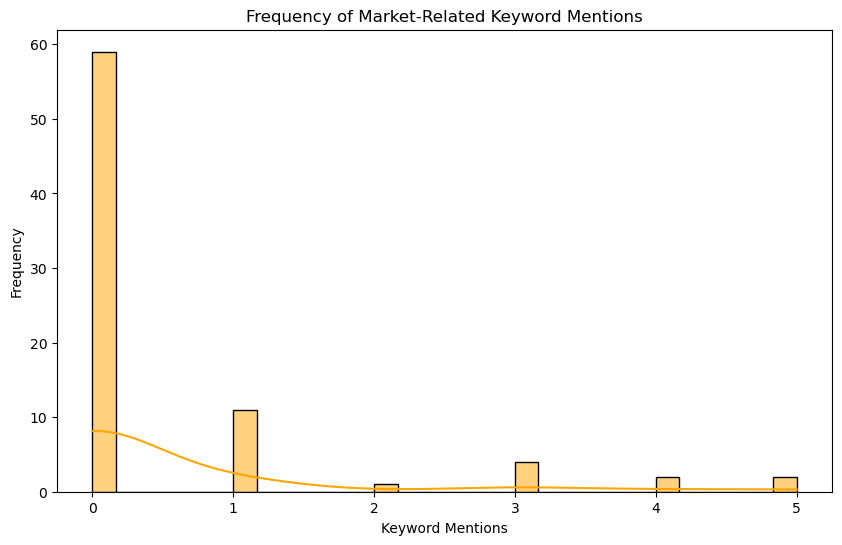

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Stock Mentions (Total Mentions)
plt.figure(figsize=(10, 6))
sns.histplot(df['total_mentions'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Stock Mentions in Titles and Bodies')
plt.xlabel('Total Mentions')
plt.ylabel('Frequency')
plt.show()

# 2. Sentiment Distribution (Title Sentiment)
plt.figure(figsize=(10, 6))
sns.histplot(df['title_sentiment'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of Sentiment Scores in Titles')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# 3. Sentiment Distribution (Body Sentiment)
plt.figure(figsize=(10, 6))
sns.histplot(df['body_sentiment'], bins=20, kde=True, color='lightcoral')
plt.title('Distribution of Sentiment Scores in Bodies')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# 4. Sentiment Trends Over Time (Assuming 'date' column exists in the dataset)
if 'date' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df['date'], y=df['title_sentiment'], label='Title Sentiment', color='blue')
    sns.lineplot(x=df['date'], y=df['body_sentiment'], label='Body Sentiment', color='red')
    plt.title('Sentiment Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# 5. Frequency of Market-Related Keywords (Example: "bull", "bear", "rally")
keywords = ['rally', 'bull', 'bear', 'crash', 'growth', 'dip']
keyword_counts = df['title_keywords'].apply(lambda x: sum(x[keyword] for keyword in keywords)).values + \
                df['body_keywords'].apply(lambda x: sum(x[keyword] for keyword in keywords)).values

plt.figure(figsize=(10, 6))
sns.histplot(keyword_counts, bins=30, kde=True, color='orange')
plt.title('Frequency of Market-Related Keyword Mentions')
plt.xlabel('Keyword Mentions')
plt.ylabel('Frequency')
plt.show()


In [25]:
df.columns

Index(['title', 'score', 'id', 'url', 'created', 'posted_date', 'body',
       'num_comments', 'clean_title', 'clean_body', 'title_sentiment',
       'body_sentiment', 'title_sentiment_label', 'body_sentiment_label',
       'title_mentions', 'body_mentions', 'total_mentions', 'title_keywords',
       'body_keywords', 'total_keywords'],
      dtype='object')

### Assign stock movement labels ('up', 'down', or 'neutral') 

In [29]:
def determine_movement(title_sentiment, body_sentiment, threshold=0.2):
    combined_sentiment = (title_sentiment + body_sentiment) / 2
    
    if combined_sentiment > threshold:
        return 'up'
    elif combined_sentiment < -threshold:
        return 'down'
    else:
        return 'neutral'

df['movement_label'] = df.apply(
    lambda row: determine_movement(row['title_sentiment'], row['body_sentiment']), axis=1
)

print(df['movement_label'].value_counts())

# Save the updated dataset to CSV for further analysis
df.to_csv("reddit_posts_with_movement_labels.csv", index=False)

print("Updated data with movement labels saved to 'reddit_posts_with_movement_labels.csv'")


movement_label
up         61
neutral    10
down        8
Name: count, dtype: int64
Updated data with movement labels saved to 'reddit_posts_with_movement_labels.csv'


### Evaluates multiple machine learning models (Logistic Regression, Random Forest, XGBoost, and Neural Network) to predict stock movement labels ('up', 'down', 'neutral') based on features like sentiment scores, post score, and number of comments.

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

df = pd.read_csv("reddit_posts_with_movement_labels.csv")


In [32]:
from sklearn.preprocessing import LabelEncoder

X = df[['title_sentiment', 'body_sentiment', 'score', 'num_comments']]  
y = df['movement_label']  

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Train and Evaluate Models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Display Results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1 Score']:.2f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])


C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0


Model: Logistic Regression
Accuracy: 0.88
Precision: 0.77
Recall: 0.88
F1 Score: 0.82
Confusion Matrix:
[[ 0  2]
 [ 0 14]]

Model: Random Forest
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[ 2  0]
 [ 0 14]]

Model: XGBoost
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[ 2  0]
 [ 0 14]]

Model: Neural Network
Accuracy: 0.88
Precision: 0.77
Recall: 0.88
F1 Score: 0.82
Confusion Matrix:
[[ 0  2]
 [ 0 14]]


C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# find the best combination of hyperparameters that maximize model performance.

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best accuracy: 0.9206349206349206


### Trains a Random Forest model using the best hyperparameters

In [87]:
best_rf_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0 0 0]
 [1 0 0]
 [0 1 0]]


C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


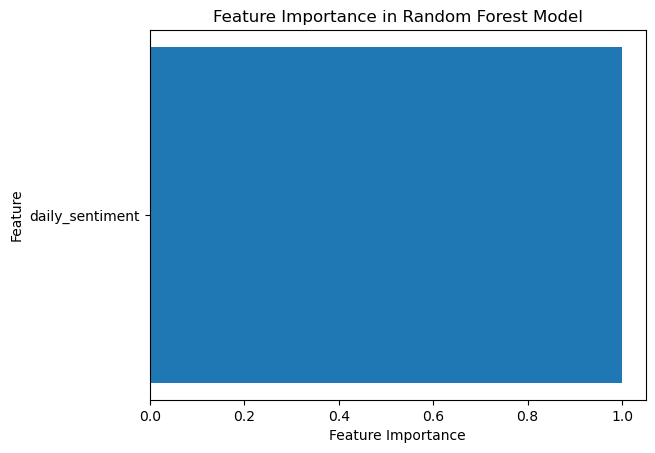

In [89]:
# importance of each feature used for making predictions.
import matplotlib.pyplot as plt
feature_importances = best_rf_model.feature_importances_
features = X.columns

plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.show()


In [91]:
#extracts all stock symbols 
all_mentions = df['title_mentions'].str.split(',').explode().tolist() + \
               df['body_mentions'].str.split(',').explode().tolist()

unique_symbols = list(set(filter(None, all_mentions)))

print("Unique stock symbols mentioned in the dataset:", unique_symbols)


Unique stock symbols mentioned in the dataset: ["{'AMD': 5", " 'GOOG': 0}", " 'TSLA': 0", " 'GOOG': 5}", " 'TSLA': 2", " 'MSFT': 0", "{'AMD': 0", "{'AMD': 1", " 'AAPL': 0"]


In [93]:
#extract stock symbols from the title_mentions and body_mentions

import ast

def extract_symbols(mentions_column):
    symbols = []
    for mention in mentions_column.dropna():
        try:
            parsed = ast.literal_eval(mention)
            symbols.extend(parsed.keys())
        except (ValueError, SyntaxError):
            pass 
    return symbols

title_symbols = extract_symbols(df['title_mentions'])
body_symbols = extract_symbols(df['body_mentions'])

unique_symbols = list(set(title_symbols + body_symbols))

print("Unique stock symbols:", unique_symbols)


Unique stock symbols: ['MSFT', 'AAPL', 'GOOG', 'TSLA', 'AMD']


In [95]:
df.columns

Index(['title', 'score', 'id', 'url', 'created', 'posted_date', 'body',
       'num_comments', 'clean_title', 'clean_body', 'title_sentiment',
       'body_sentiment', 'title_sentiment_label', 'body_sentiment_label',
       'title_mentions', 'body_mentions', 'total_mentions', 'title_keywords',
       'body_keywords', 'total_keywords', 'movement_label', 'day_sentiment'],
      dtype='object')

In [97]:
# Date Range:

df['posted_date'] = pd.to_datetime(df['posted_date'])
# Check the date range
print("Data starts from:", df['posted_date'].min())
print("Data ends on:", df['posted_date'].max())


Data starts from: 2024-11-11 00:00:00
Data ends on: 2024-11-26 00:00:00


In [99]:
# average daily sentiment by combining the sentiment scores from both the title and body columns, then groups the data by posted date to calculate the daily average sentiment.

df['day_sentiment'] = df[['title_sentiment', 'body_sentiment']].mean(axis=1)

daily_sentiment = df.groupby('posted_date').agg(
    daily_sentiment=('day_sentiment', 'mean'),
).reset_index()

print(daily_sentiment.head())  # Check the first few rows

  posted_date  daily_sentiment
0  2024-11-11         0.454400
1  2024-11-12         0.516200
2  2024-11-13         0.471430
3  2024-11-14         0.149380
4  2024-11-15         0.486157


## Alpha Vantage
### provides APIs for accessing financial data, including stock prices, cryptocurrency data, forex rates, and technical indicators.

In [102]:
pip install alpha_vantage

Note: you may need to restart the kernel to use updated packages.


#### Script fetches historical stock price data for a list of stock symbols using the Alpha Vantage API, and then merges this stock data with a daily sentiment dataset.

In [104]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

api_key = "JF42APDHAEKOYHSG"  
ts = TimeSeries(key=api_key, output_format="pandas")

stock_symbols = [
    'AAPL', 'GOOGL', 'AMZN', 'TSLA', 'MSFT', 'META', 'NVDA', 'NFLX', 'INTC', 'AMD',  # Tech
    'SPY', 'QQQ', 'DIA',  # ETFs
    'BA', 'GE', 'NKE', 'V', 'MA',  # Industrials & Financials
    'DIS', 'PEP', 'KO', 'MCD', 'T', 'VZ',  # Consumer Discretionary & Staples
    'GS', 'JPM', 'C', 'BAC', 'WFC',  # Banks
    'XOM', 'CVX', 'COP', 'BP', 'RDS.A',  # Energy & Oil
    'WMT', 'COST', 'HD', 'LOW',  # Retail
    'CVS', 'UNH', 'PFE', 'JNJ', 'MRK',  # Healthcare
    'LUV', 'AAL', 'DAL',  # Airlines
    'IBM', 'ORCL', 'SAP',  # Software & Cloud
    'BABA', 'JD', 'TSM',  # Chinese companies
    'ABT', 'MDT', 'ISRG', 'SYK',  # Medical Devices
    'GS', 'MS', 'BLK', 'SCHW',  # Investment Firms
    'PYPL', 'SQ', 'MA', 'ADBE',  # Payment Systems & Fintech
    'RBLX', 'UBER', 'LYFT', 'SQ', 'SHOP'  # Other tech and new economy stocks
]

historical_data = {}

for symbol in stock_symbols:
    print(f"Fetching data for {symbol}...")
    try:
        stock_data, meta_data = ts.get_daily(symbol=symbol, outputsize="full")
        stock_data.reset_index(inplace=True) 
        stock_data.rename(columns={'date': 'posted_date', '4. close': 'Close'}, inplace=True)  
        stock_data['posted_date'] = pd.to_datetime(stock_data['posted_date']) 
        historical_data[symbol] = stock_data[['posted_date', 'Close']]
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

aapl_data = historical_data.get('AAPL')  

if aapl_data is not None:
    daily_sentiment['posted_date'] = pd.to_datetime(daily_sentiment['posted_date'])  
    merged_data = pd.merge(daily_sentiment, aapl_data, on="posted_date", how="inner")

    print(merged_data.head())
else:
    print("AAPL data could not be fetched.")


Fetching data for AAPL...
Fetching data for GOOGL...
Fetching data for AMZN...
Fetching data for TSLA...
Fetching data for MSFT...
Fetching data for META...
Fetching data for NVDA...
Fetching data for NFLX...
Fetching data for INTC...
Fetching data for AMD...
Fetching data for SPY...
Fetching data for QQQ...
Fetching data for DIA...
Fetching data for BA...
Fetching data for GE...
Fetching data for NKE...
Fetching data for V...
Fetching data for MA...
Fetching data for DIS...
Fetching data for PEP...
Fetching data for KO...
Fetching data for MCD...
Fetching data for T...
Fetching data for VZ...
Fetching data for GS...
Fetching data for JPM...
Fetching data for C...
Error fetching data for C: Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.
Fetching data for BAC...
Error fetching data for BAC: Thank you for using Alpha Vanta

In [105]:
# Check the first few rows of the merged data
print(merged_data.head())

  posted_date  daily_sentiment   Close
0  2024-11-11         0.454400  224.23
1  2024-11-12         0.516200  224.23
2  2024-11-13         0.471430  225.12
3  2024-11-14         0.149380  228.22
4  2024-11-15         0.486157  225.00


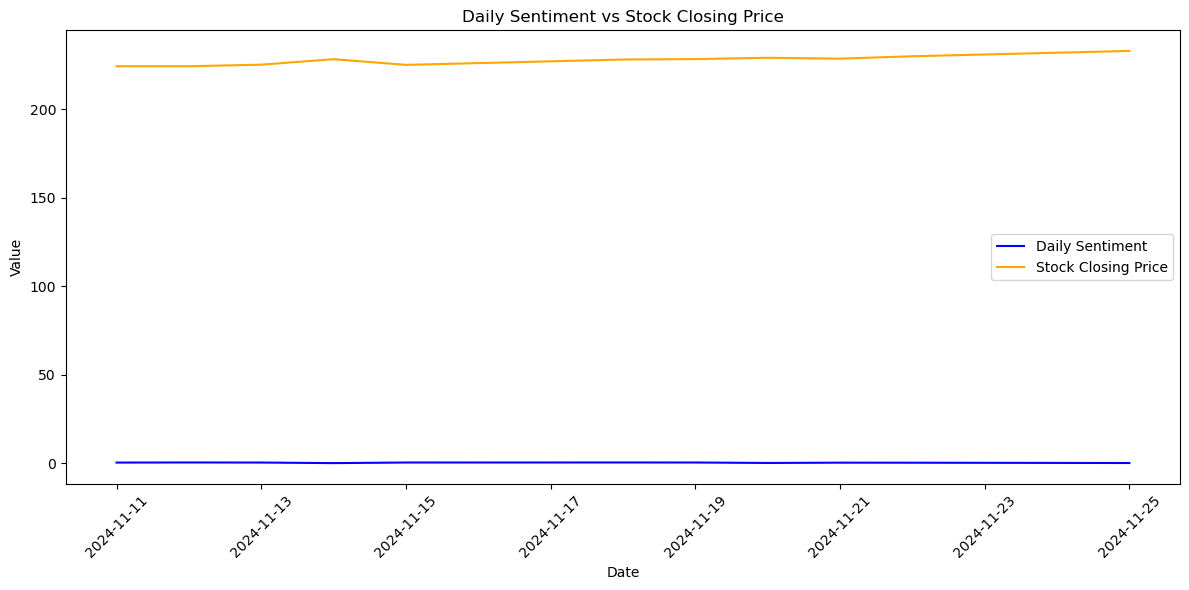

In [106]:
import matplotlib.pyplot as plt

# Plot daily sentiment vs stock price
plt.figure(figsize=(12, 6))
plt.plot(merged_data['posted_date'], merged_data['daily_sentiment'], label='Daily Sentiment', color='blue')
plt.plot(merged_data['posted_date'], merged_data['Close'], label='Stock Closing Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Daily Sentiment vs Stock Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [107]:
# Check the correlation between sentiment and stock price
correlation = merged_data[['daily_sentiment', 'Close']].corr()
print(correlation)


                 daily_sentiment     Close
daily_sentiment         1.000000 -0.653348
Close                  -0.653348  1.000000


In [108]:
merged_data['price_change'] = merged_data['Close'].pct_change() * 100  # Percentage change in stock price

merged_data['movement_label'] = pd.cut(merged_data['price_change'],
                                       bins=[-float('inf'), -0.5, 0.5, float('inf')],
                                       labels=['down', 'neutral', 'up'])

merged_data = merged_data.dropna()

print(merged_data['movement_label'].value_counts())

movement_label
neutral    5
up         4
down       1
Name: count, dtype: int64


In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = merged_data[['daily_sentiment']] 
y = merged_data['movement_label'] 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(8, 1) (2, 1)


In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(max_iter=500)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)


Accuracy: 0.50
Confusion Matrix:
[[1 0]
 [1 0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [112]:
print(merged_data['movement_label'].value_counts())

movement_label
neutral    5
up         4
down       1
Name: count, dtype: int64
